# Progetto Machine Learning: language identification

### Load libraries

In [174]:
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import string
import collections
import pickle

## Text to feature vector

In [175]:
def parse_string(word, lang = None):
    str(word)
    word = strip_accents(word.lower())
    length = len(word)
    LetterFreq={}
    for letter in string.ascii_lowercase:
        LetterFreq[letter] = 0
    for letter in word.lower():
        LetterFreq[letter] += 1
    features = list(LetterFreq.values())
    if(length > 0):
        features = [float(x)/length for x in features]
    
    features.append(length)
    
    if(lang != None):
        features.append(lang)
    
    return features

## Removing accents

In [176]:
def strip_accents(word):
    table = collections.defaultdict(lambda: None)
    table.update({
        ord('é'): 'e',
        ord('ô'): 'o',
        ord('è'): 'e',
        ord('à'): 'a',
        ord('ì'): 'i',
        ord('ù'): 'u',
        ord('\n'): '',
    })
    table.update(dict(zip(map(ord,string.ascii_uppercase), string.ascii_lowercase)))
    table.update(dict(zip(map(ord,string.ascii_lowercase), string.ascii_lowercase)))
    table.update(dict(zip(map(ord,string.digits), string.digits)))
    return word.translate(table,)

### Load dataset

In [177]:
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
         'U', 'V', 'W','X', 'Y', 'Z', 'Length', 'class']

dataset_it = DataFrame((parse_string(word,'Italian') for word in open('./Data/italian.txt', encoding = "ISO-8859-1")), columns = names)
dataset_en = DataFrame(([parse_string(word,'English') for word in open('./Data/english.txt', encoding = "ISO-8859-1")]), columns=names)
dataset_zh = DataFrame(([parse_string(word,'Chinese') for word in open('./Data/chinese.txt', encoding = "ISO-8859-1")]) , columns = names)

In [181]:
dataset = DataFrame()
dataset = dataset.append(dataset_it)
dataset = dataset.append(dataset_en)
dataset = dataset.append(dataset_zh)

### Dataset analysis 

In [182]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:27]
Y = array[:,27]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=validation_size, random_state=seed)

# Spot-Check Algorithms
models=[]
models.append(('LR', LogisticRegression(multi_class='auto', solver='liblinear')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [183]:
# evalutate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.771613 (0.007750)


/home/andrea/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.765324 (0.007190)
KNN: 0.735471 (0.011816)
CART: 0.708522 (0.009032)
NB: 0.705965 (0.013917)
SVM: 0.749844 (0.009352)


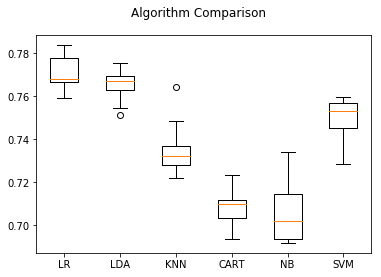

In [184]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [185]:
# Make predictions on validation dataset
model = LogisticRegression(multi_class='auto', solver='liblinear')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.775290215588723
[[1389   31   71]
 [ 126  627  287]
 [ 104  194  789]]
              precision    recall  f1-score   support

     Chinese       0.86      0.93      0.89      1491
     English       0.74      0.60      0.66      1040
     Italian       0.69      0.73      0.71      1087

   micro avg       0.78      0.78      0.78      3618
   macro avg       0.76      0.75      0.75      3618
weighted avg       0.77      0.78      0.77      3618



## Practical demo

In [225]:
test_string = "Test"
print("The word", test_string, "was recognised as", lr.predict([parse_string(test_string)]).take(0))

The word Test was recognised as English


## Save current model to file

In [226]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Load saved model

In [170]:
model = pickle.load(open(filename, 'rb'))
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
